<a href="https://colab.research.google.com/github/Pulsar-kkaturi/Deepnoid-Education/blob/master/Lecture3_Inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![대체 텍스트](https://raw.githubusercontent.com/deepnoid/education/master/7.%20Deep%20Learning%20Keras/dataset/deepnoid_logo.jpg)

In [1]:
!git clone https://github.com/Pulsar-kkaturi/Deepnoid-Education.git

Cloning into 'Deepnoid-Education'...
remote: Enumerating objects: 314, done.
remote: Counting objects: 100% (314/314), done.
remote: Compressing objects: 100% (265/265), done.
remote: Total 314 (delta 118), reused 199 (delta 47), pack-reused 0
Receiving objects: 100% (314/314), 37.90 MiB | 22.34 MiB/s, done.
Resolving deltas: 100% (118/118), done.


# 모듈 불러오기

In [2]:
from keras import applications, optimizers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.layers import *
from skimage.transform import rotate
from skimage import exposure
import matplotlib.pyplot as plt
import numpy as np
import os

# 경로 설정하기

In [35]:
BASE_PATH = './Deepnoid-Education/dataset/xray_abd_chest'
TRAIN_DATA_PATH = os.path.join(BASE_PATH, 'TRAIN')
VAL_DATA_PATH = os.path.join(BASE_PATH, 'VAL')
TEST_DATA_PATH = os.path.join(BASE_PATH, 'TEST', 'chest1.png')

In [4]:
TRAIN_DATA_PATH

'./Deepnoid-Education/dataset/xray_abd_chest/TRAIN'

# 하이퍼 파라미터

하이퍼 파라미터를 이용해 인공지능 모델을 조정합니다.  
주로 사용하는 하이퍼 파라미터는 다음과 같습니다.

In [5]:
IMG_HEIGHT, IMG_WIDTH = (256, 256)
EPOCHS = 10
BATCH_SIZE = 5
LEARNING_RATE = 1e-4
DECAY_RATE = 0

# 데이터 불러오기

AI 모델 학습에 사용할 데이터를 불러오겠습니다.  
케라스의 **ImageDataGenerator** 함수를 사용해 손쉽게 데이터를 불러올 수 있습니다.  


또한 데이터를 불러올 때 옵션을 활용해 **Augmentation** 도 할 수 있습니다.

In [6]:
train_datagen = ImageDataGenerator(width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   rescale=1/255.)
val_datagen = ImageDataGenerator(rescale=1/255.)

**flow_from_directory** 함수는 지정해둔 폴더 내의 이미지와 레이블을 자동으로 불러오는 함수입니다.  
이 함수를 이용해 훈련 데이터와 검증 데이터를 불러오겠습니다.

In [7]:
train_generator = train_datagen.flow_from_directory(directory=TRAIN_DATA_PATH,
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='binary',
                                                    shuffle=True,
                                                    seed=42)
val_generator = val_datagen.flow_from_directory(directory=VAL_DATA_PATH,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                batch_size=1,
                                                class_mode='binary',
                                                shuffle=False,
                                                seed=42)

Found 65 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


# 데이터 전처리

데이터를 불러온 후 AI 모델의 성능을 높일 수 있는 몇 가지 전처리를 진행합니다.  
특히 절대적인 데이터 양이 부족한 의료 인공지능 훈련 시에는  
데이터 양을 **Augmentation** 기술을 이용해 늘릴 수 있습니다. 

먼저 원본 이미지의 특징은 다음과 같습니다.

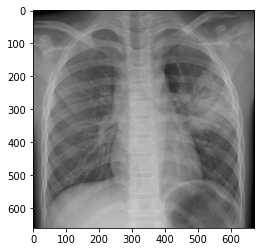

In [36]:
img = plt.imread(TEST_DATA_PATH)
plt.imshow(img, cmap='Greys')
plt.show()

이미지의 형태는 (489, 404, 3) 으로  
세로 **489** 가로 **404** 채널 **3(RGB)** 의 이미지를 불러왔다는 의미입니다.

In [37]:
np.shape(img)

(661, 673, 3)

그리고 위 이미지를 컴퓨터가 실제로 인식하는 숫자 데이터로 확인해보겠습니다.

In [38]:
img

array([[[0.01568628, 0.01568628, 0.01568628],
        [0.01960784, 0.01960784, 0.01960784],
        [0.01568628, 0.01568628, 0.01568628],
        ...,
        [0.16862746, 0.16862746, 0.16862746],
        [0.16862746, 0.16862746, 0.16862746],
        [0.16470589, 0.16470589, 0.16470589]],

       [[0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784],
        ...,
        [0.18039216, 0.18039216, 0.18039216],
        [0.18039216, 0.18039216, 0.18039216],
        [0.18039216, 0.18039216, 0.18039216]],

       [[0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784],
        [0.02352941, 0.02352941, 0.02352941],
        ...,
        [0.19215687, 0.19215687, 0.19215687],
        [0.19215687, 0.19215687, 0.19215687],
        [0.19215687, 0.19215687, 0.19215687]],

       ...,

       [[0.01960784, 0.01960784, 0.01960784],
        [0.01176471, 0.01176471, 0.01176471],
        [0.01176471, 0

Augmentation 은 위와 같이 숫자로 이루어진 이미지 데이터를 가공하여  
원본과 유사하지만 다른 새로운 이미지를 만드는 기법입니다.

이 중 **로테이션 기법** 을 살펴보겠습니다. 

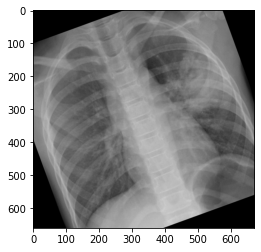

In [39]:
img_rot = rotate(img, 20)
plt.imshow(img_rot)
plt.show()

다음으로 **이동** 기법을 살펴보겠습니다.

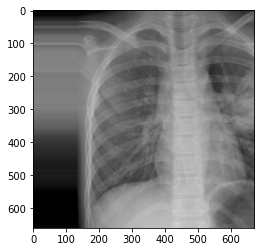

In [40]:
img_shift = image.random_shift(img, 0.2, 0.2)
plt.imshow(img_shift)
plt.show()

**감마 변경** 도 해봅시다.

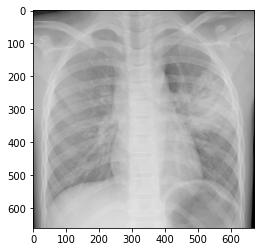

In [41]:
img_gamma = exposure.adjust_gamma(img, gamma=0.5)
plt.imshow(img_gamma)
plt.show()

**좌우 반전** 은 다음과 같습니다.

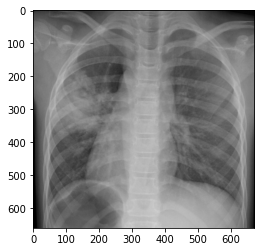

In [42]:
img_hflip = np.fliplr(img)
plt.imshow(img_hflip)
plt.show()

다음으로 **상하 반전** 을 확인해보겠습니다.

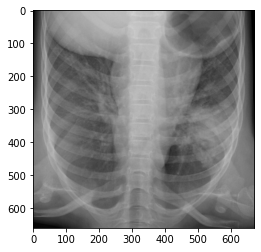

In [43]:
img_vflip = np.flipud(img)
plt.imshow(img_vflip)
plt.show()

그렇다면 이 모든 기법을 동시에 적용해볼까요?  
처음 이미지와 상당히 다른 새로운 이미지가 만들어집니다.

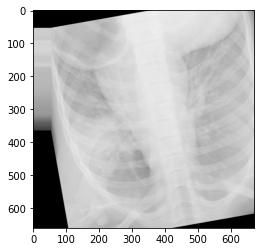

In [44]:
img_rot = rotate(img, 10)
img_shift = image.random_shift(img_rot, 0.1, 0.1)
img_gamma = exposure.adjust_gamma(img_shift, gamma=0.3)
img_hflip = np.fliplr(img_gamma)
img_vflip = np.flipud(img_hflip)
plt.imshow(img_vflip)
plt.show()

# **X-ray 이미지 구분하는 AI 모델 만들기**

AI 모델을 만드는 방법은 크게  

1) 모듈에서 제공하는 이미 훈련된 모델을 불러오는 방법과  
2) 자신만의 새로운 모델을 만드는 방법이 있습니다.

저희의 모델을 만들기 전에 우선 손쉽게 사용할 수 있도록 **이미 훈련된 모델을 사용** 해보겠습니다.  
가볍고 성능이 좋아 자주 사용되는 **Inception 모델** 을 불러오겠습니다.

In [17]:
basemodel = applications.inception_v3.InceptionV3(weights='imagenet',
                                                  include_top=False,
                                                  input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
model_top = Sequential()
model_top.add(GlobalAveragePooling2D())
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(1, activation='sigmoid'))



model = Model(inputs=basemodel.input, outputs=model_top(basemodel.output))
model.compile(optimizer=Adam(lr=LEARNING_RATE,
                             epsilon=1e-8,
                             decay=DECAY_RATE),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

87916544/87910968 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_____________________________

1. score 그대로 내보내는 방법 : 구체적인 값이 필요한 경우(강수확률, 주가 예측, 복권 당첨 확률)
2. 0~1사이의 값으로 -> sigmoid : (None, 1) -> 0~1 줄 세우기, 0또는1 binary classification
3. (None, 3) 으로 나타내기 -> softmax : [0.51, 1.25, 3.12] -> 포도 (rgb, 국영수사과, 사과 배 포도)
(None, 2) [0.2, 1.6] -> abdo

# AI 모델 훈련하기

이렇게 준비한 AI 모델을 fit_generator 함수를 이용해 훈련시킬 수 있습니다.

In [18]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=train_generator.n // BATCH_SIZE,
                              epochs=EPOCHS,
                              validation_data=val_generator,
                              validation_steps=val_generator.n // BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
13/13 [==============================] - 52s 3s/step - loss: 0.6424 - accuracy: 0.6357 - val_loss: 0.0956 - val_accuracy: 1.0000
Epoch 2/10
13/13 [==============================] - 42s 3s/step - loss: 0.2862 - accuracy: 0.8597 - val_loss: 0.0141 - val_accuracy: 1.0000
Epoch 3/10
13/13 [==============================] - 42s 3s/step - loss: 0.1961 - accuracy: 0.9262 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 4/10
13/13 [==============================] - 42s 3s/step - loss: 0.0678 - accuracy: 0.9769 - val_loss: 0.0076 - val_accuracy: 1.0000
Epoch 5/10
13/13 [==============================] - 42s 3s/step - loss: 0.0396 - accuracy: 1.0000 - val_loss: 0.0050 - val_accuracy: 1.0000
Epoch 6/10
13/13 [==============================] - 42s 3s/step - loss: 0.0904 - accuracy: 0.9785 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 7/10
13/13 [==============================] - 42s 3s/step - loss: 0.1304 - accuracy: 0.9382 - val_loss: 4.7813e-04 - val_accuracy: 1.0000
Epoch 8/10
13/13

# 훈련 결과 확인하기

훈련 결과를 한 눈에 확인할 수 있는 그래프를 만들어 보겠습니다.

먼저 그래프의 **y축에 사용할 값**들을 **history 항목**에서 추출해 봅시다.

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

다음으로 그래프의 **x축 값**으로 사용할 **epoch** 을 뽑아 보겠습니다.

In [22]:
epochs = range(1, len(acc)+1)

값들을 확인해볼까요?

In [23]:
acc

[0.7692307829856873,
 0.8769230842590332,
 0.9076923131942749,
 0.9538461565971375,
 1.0,
 0.9538461565971375,
 0.9230769276618958,
 0.9384615421295166,
 1.0,
 1.0]

In [24]:
val_acc

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [25]:
loss

[0.5189972519874573,
 0.25099050998687744,
 0.2170933336019516,
 0.11374430358409882,
 0.03883162513375282,
 0.17572729289531708,
 0.15997828543186188,
 0.18090608716011047,
 0.029194876551628113,
 0.014338241890072823]

In [26]:
val_loss

[0.09558073431253433,
 0.014122534543275833,
 0.006264244206249714,
 0.007620309013873339,
 0.004953707568347454,
 0.0020700597669929266,
 0.00047812541015446186,
 2.3517399313277565e-05,
 1.2927418993058382e-06,
 6.688389930786798e-07]

In [27]:
list(epochs)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

이 값들을 이용해 그래프를 만들어 보겠습니다.

먼저 정확도 그래프를 그려볼까요?

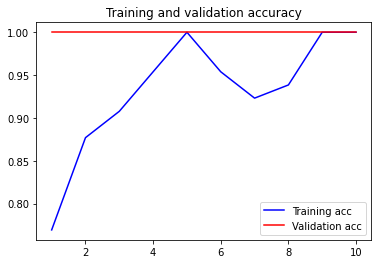

In [28]:
plt.plot(epochs, acc, 'b', color='blue', label='Training acc')
plt.plot(epochs, val_acc, 'b', color='red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

다음으로 손실 그래프를 살펴보겠습니다.

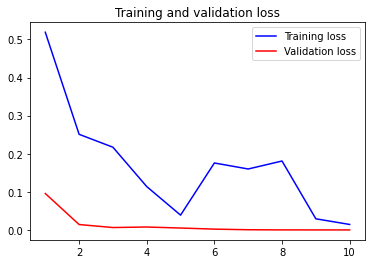

In [29]:
plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
plt.plot(epochs, val_loss, 'b', color='red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# 테스트하기

마지막으로 AI 모델이 실제로 X-ray 이미지를 잘 분류하는지 확인해보겠습니다.

먼저 미리 준비한 테스트 이미지 경로를 입력한 후,

In [45]:
img1_path = os.path.join(BASE_PATH, 'TEST', 'chest2.png')
img2_path = os.path.join(BASE_PATH, 'TEST', 'abd2.png')

load_img 함수를 이용해 이미지를 불러옵니다.

In [46]:
img1 = image.load_img(img1_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
img2 = image.load_img(img2_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

첫번째 이미지를 확인해봅시다.

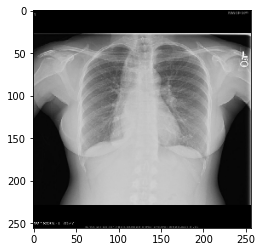

In [47]:
plt.imshow(img1)
plt.show()

그 후 AI 모델에 넣을 수 있는 형태로 가공하고

In [48]:
img1 = image.img_to_array(img1)
img1 /= 255.
img1 = img1[np.newaxis, :, :, :]

결과를 확인하면 AI 모델은 다음과 같이 Chest X-ray 라고 정확히 판단합니다. 

In [49]:
score1 = model.predict(img1)
print('Predicted:', 'Chest X-ray' if score1 < 0.5 else 'Abd X-ray', ', Score:', score1[0,0])

Predicted: Chest X-ray , Score: 5.930332e-05


두번째 이미지도 테스트해볼까요?

먼저 이미지를 출력해본 후

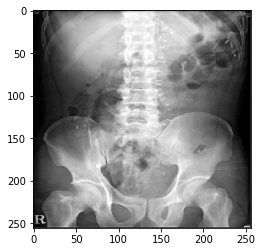

In [50]:
plt.imshow(img2)
plt.show()

AI 모델에 넣을 준비를 하고

In [51]:
img2 = image.img_to_array(img2)
img2 /= 255.
img2 = img2[np.newaxis, :, :, :]

예측을 해봅시다!

In [52]:
score2 = model.predict(img2)
print('Predicted: ', 'Chest X-ray' if score2 < 0.5 else 'Abd X-ray', ', Score:', score2[0,0])

Predicted:  Abd X-ray , Score: 0.98762
